In [1]:
import itertools
import seaborn as sb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib
import math

plt.style.use("dark_background")

In [2]:
data = pd.read_csv("D:/Github/Programming/Data Science/Machine Learning/Time Series/Datasets/Air Passengers/AirPassengers.csv")

data = data.rename({"Month": "month", "#Passengers": "passengers"}, axis=1)
data["month"] = pd.to_datetime(data["month"])
data = data.set_index("month")
data = data.asfreq(freq="MS")

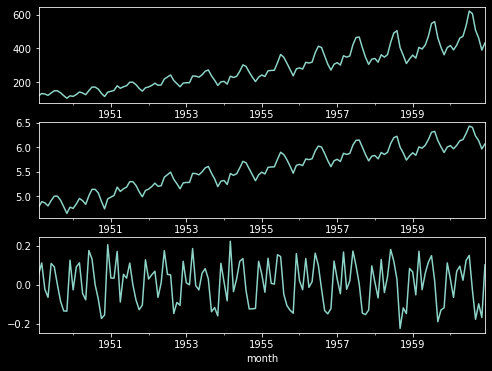

In [3]:
data["passengers_log"] = np.log(data["passengers"])
data["passengers_log_diff"] = data["passengers_log"].diff(1)
data = data.dropna()

fig, axes = plt.subplots(3, 1, figsize=(8, 6))
data["passengers"].plot.line(ax=axes[0]);
data["passengers_log"].plot.line(ax=axes[1]);
data["passengers_log_diff"].plot.line(ax=axes[2]);

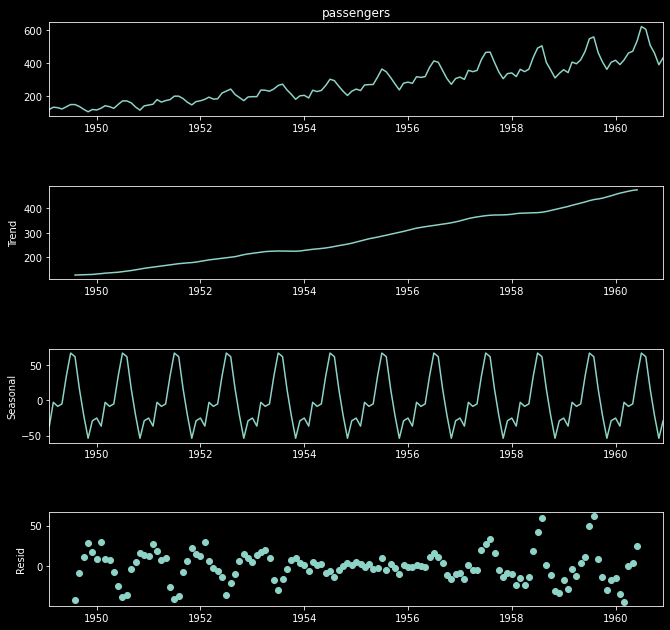

In [4]:
decomp = sm.tsa.seasonal_decompose(data["passengers"], model="additive")
fig = decomp.plot()
fig.set_size_inches(10, 10)

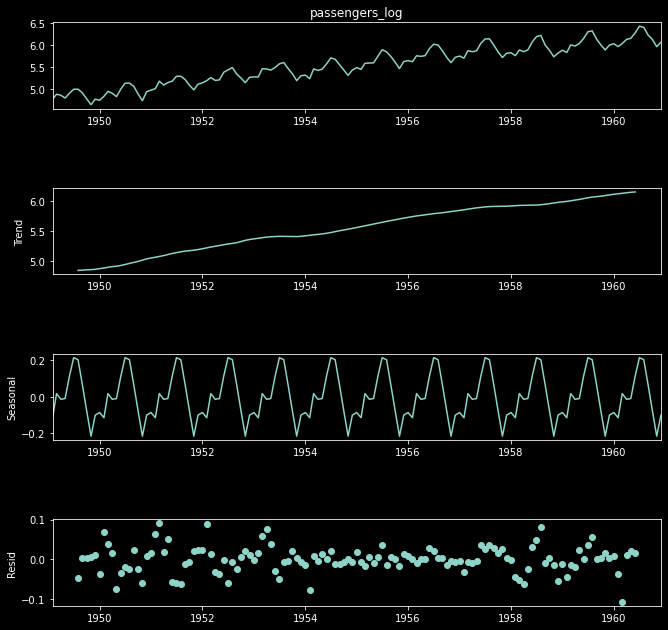

In [5]:
decomp = sm.tsa.seasonal_decompose(data["passengers_log"], model="additive")
fig = decomp.plot()
fig.set_size_inches(10, 10)

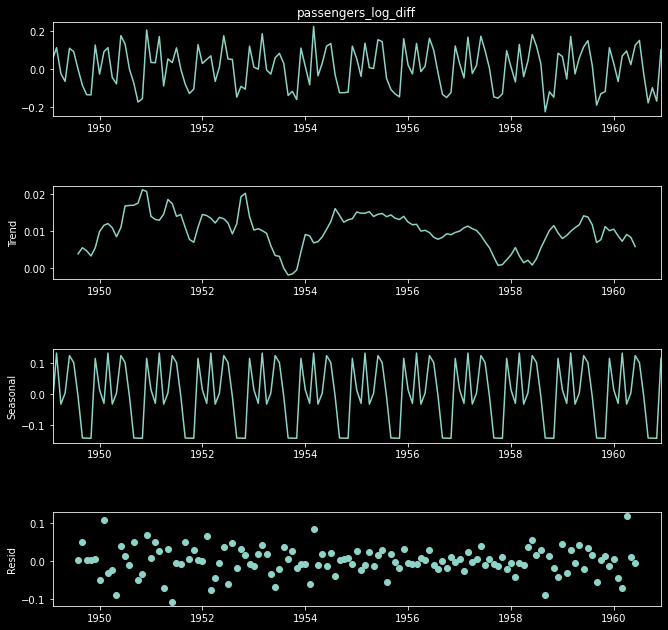

In [6]:
decomp = sm.tsa.seasonal_decompose(data["passengers_log_diff"], model="additive")
fig = decomp.plot()
fig.set_size_inches(10, 10)

In [7]:
data_tr, data_te = train_test_split(data, test_size=0.2, shuffle=False)

C:\Users\82104\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


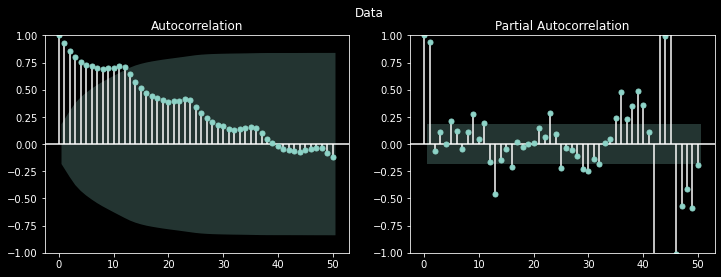

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Data")

sm.graphics.tsa.plot_acf(ax=axes[0], x=data_tr["passengers_log"], lags=50);
sm.graphics.tsa.plot_pacf(ax=axes[1], x=data_tr["passengers_log"], lags=50);

C:\Users\82104\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


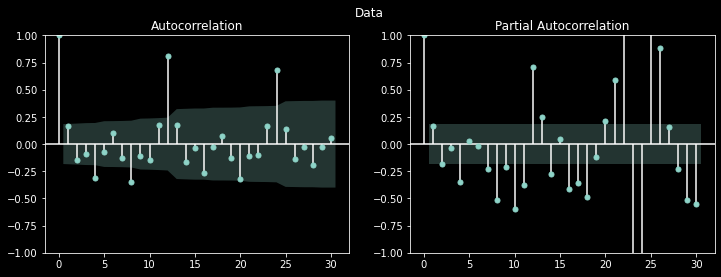

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Data")

sm.graphics.tsa.plot_acf(ax=axes[0], x=data_tr["passengers_log_diff"], lags=30);
sm.graphics.tsa.plot_pacf(ax=axes[1], x=data_tr["passengers_log_diff"], lags=30);

# Non-Seasonal ARIMA Modeling

## Hyperparameter Tunning

### Implementation

C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramete

best_params: (1, 1, 2)
r2_score: -0.1446914082682802


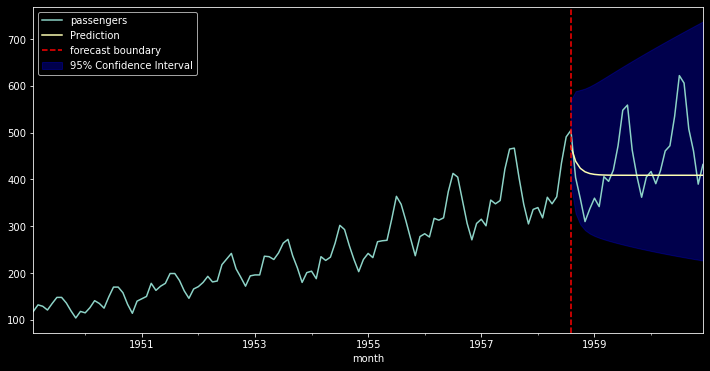

In [10]:
minim = math.inf
for params in itertools.product(range(0, 3), range(0, 2), range(0, 3)):
    model = SARIMAX(endog=data_tr["passengers_log"], order=params)
    hist = model.fit()
    aic = hist.aic
    if aic < minim:
        minim = aic
        best_params = params
print(f"best_params: {best_params}")

model = SARIMAX(data_tr["passengers_log"], order=best_params)
hist = model.fit()
hist.summary()

pred_res = hist.get_forecast(len(data_te))
preds = np.exp(pred_res.predicted_mean)
preds_lb = np.exp(pred_res.conf_int().iloc[:, 0])
preds_ub = np.exp(pred_res.conf_int().iloc[:, 1])

fig = plt.figure(figsize=(12, 6))
data["passengers"].plot.line();
preds.plot.line(label="Prediction");
plt.axvline(x="1958-08-01", linestyle="--", color="r", label="forecast boundary");
plt.fill_between(x=data_te.index, y1=preds_lb, y2=preds_ub, color="b", alpha=0.3, label="95% Confidence Interval");
plt.legend(loc="upper left");
print(f"r2_score: {r2_score(data_te['passengers'], preds)}")

# Seasonal ARIMA Modeling

C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\82104\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\82104\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


r2_score: 0.9191271726184944


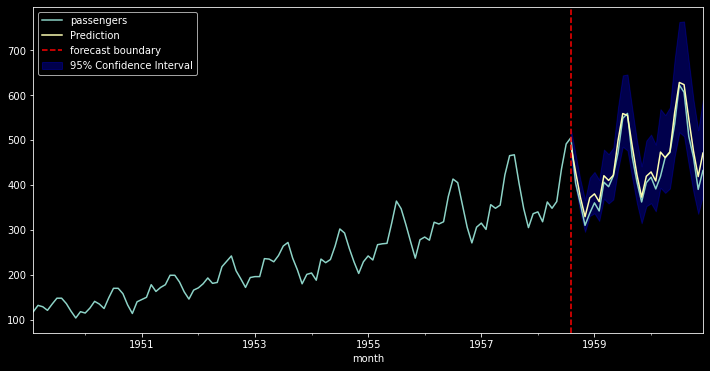

In [11]:
model = SARIMAX(data_tr["passengers_log"], order=(2, 1, 1), seasonal_order=best_params + (12,))
hist = model.fit()
hist.summary()

pred_res = hist.get_forecast(len(data_te))
preds = np.exp(pred_res.predicted_mean)
preds_lb = np.exp(pred_res.conf_int().iloc[:, 0])
preds_ub = np.exp(pred_res.conf_int().iloc[:, 1])

fig = plt.figure(figsize=(12, 6))
data["passengers"].plot.line();
preds.plot.line(label="Prediction");
plt.axvline(x="1958-08-01", linestyle="--", color="r", label="forecast boundary");
plt.fill_between(x=data_te.index, y1=preds_lb, y2=preds_ub, color="b", alpha=0.3, label="95% Confidence Interval");
plt.legend(loc="upper left");
print(f"r2_score: {r2_score(data_te['passengers'], preds)}")

## Hyperparameter Tunning

### Using `pmdarima.arima.auto_arima()`

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-364.000, Time=0.86 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-332.160, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-361.128, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-367.427, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-341.705, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-365.702, Time=0.38 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-365.773, Time=0.62 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-361.787, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-363.603, Time=0.83 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-359.970, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-365.779, Time=0.54 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-365.498, Time=0.37 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-367.123, Time=0.26 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-363.840, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1

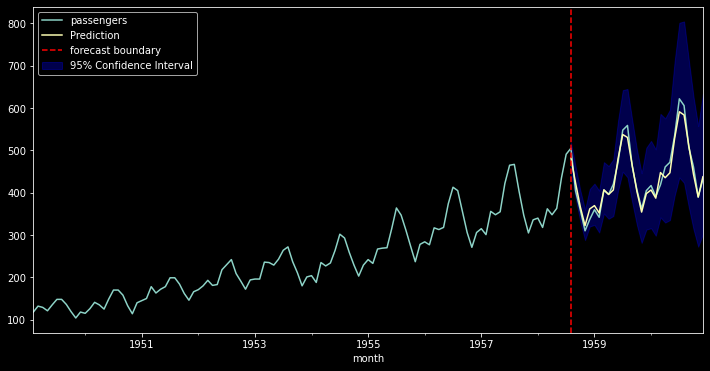

In [13]:
model = auto_arima(data_tr["passengers_log"], start_p=1, max_p=3, d=1, start_q=1, max_q=3, seasonal=True, max_P=3, D=1, max_Q=3, m=12, trace=True, error_action="ignore")

pred_res = model.predict(len(data_te), return_conf_int=True)
preds = pd.Series(np.exp(pred_res[0]), index=data_te.index)
preds_lb = pd.Series(np.exp(pred_res[1])[:, 0], index=data_te.index)
preds_ub = pd.Series(np.exp(pred_res[1])[:, 1], index=data_te.index)

# model = SARIMAX(data_tr["passengers_log"], order=model.order, seasonal_order=model.seasonal_order)
# hist = model.fit()
# hist.summary()

# pred_res = hist.get_forecast(len(data_te))
# preds = np.exp(pred_res.predicted_mean)
# preds_lb = np.exp(pred_res.conf_int().iloc[:, 0])
# preds_ub = np.exp(pred_res.conf_int().iloc[:, 1])

fig = plt.figure(figsize=(12, 6))
data["passengers"].plot.line();
preds.plot.line(label="Prediction");
plt.axvline(x="1958-08-01", linestyle="--", color="r", label="forecast boundary");
plt.fill_between(x=data_te.index, y1=preds_lb, y2=preds_ub, color="b", alpha=0.3, label="95% Confidence Interval");
plt.legend(loc="upper left");
print(f"r2_score: {r2_score(data_te['passengers'], preds)}")